In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
from halotools import utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
#import corner
from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare

In [2]:
threshold = 21
dname = "zehavi_data_file_21"
param = "mvir"

In [3]:
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [4]:
def calc_chi2(obs,exp,var):
    chi2s = []
    diff = obs-exp
    chi2 = np.sum(diff**2/var)
    chi2s.append(round(chi2,7))
        
    return chi2s

In [13]:
fname = 'combo_param_allparam_fit_a1_m21.h5'
files = [fname]

#files = [fname4,fname5]
s = []
log_prob_s = []
wps = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wps.append(reader.get_blobs(discard=1000))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))

if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    
print("Min chi2:",round(-2*log_prob_samples.max(),3))
print("Min chi2 params:",list(np.array(samples[np.where(log_prob_samples==log_prob_samples.max())]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])

#calculate chi2 per degree of freedom
deg_of_frdm = 6
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<5.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],100,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])
a,logMmin,sigma_logM,alpha,logM0,logM1 = list(np.array(samples[np.where(log_prob_samples==log_prob_samples.max())]))[0]

()
(1, 74000, 35, 6)
(1, 74000, 35)
Min chi2: 2.01
Min chi2 params: [0.55811521 8.17166921 0.20001981 1.41139431 8.37309625 8.93763237]
chi2 per dof: 0.33491937249351067
median,max,std:  10.402583284392959 45.15790047612072 3.8983110077818446


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.374 secs


chi2:  [6.3677561]
ng:  0.001161921875
ng data:  0.00116


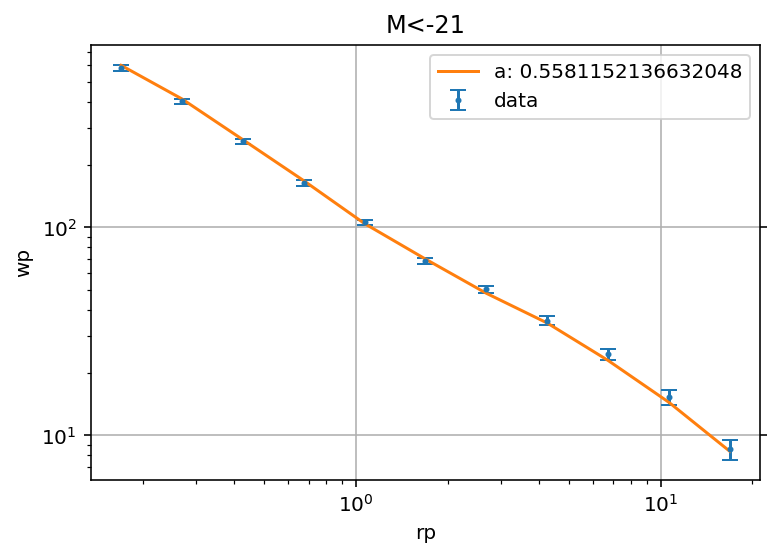

In [14]:
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
calc_ng = []
wp_res = []
for i in range(1):#param_sampling:
    halocat.halo_table.add_column((halocat.halo_table['halo_mvir']**a)*(halocat.halo_table['halo_vmax']**(1-a)),name='combo')
    """
    new_colname = 'combo'
    new_coltype = 'f4'
    grouping_key = 'halo_hostid'
    def lin_combo_mass_c(mass, c):
        return (mass**a)*(c**(1-a))
    aggregation_function = lin_combo_mass_c
    colnames_needed_by_function = ['halo_mvir','halo_vmax']
    sorting_keys = ['halo_hostid', 'halo_upid']
    add_new_table_column(halocat.halo_table, new_colname, new_coltype, grouping_key, 
                     aggregation_function, colnames_needed_by_function, 
                     sorting_keys=sorting_keys)
    """
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'combo',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'combo', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
    halocat.redshift = 0.
    pi_max = 60.
    Lbox = 400.

    model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
    model_instance.param_dict['logMmin'] = logMmin
    model_instance.param_dict['sigma_logM'] = sigma_logM
    model_instance.param_dict['alpha'] = alpha
    model_instance.param_dict['logM0'] = logM0
    model_instance.param_dict['logM1'] = logM1

    try:
        model_instance.mock.populate()
    except:
        model_instance.populate_mock(halocat)
        
    halo_table = model_instance.mock.halo_table
    pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], model_instance.mock.galaxy_table['y'],
                                 model_instance.mock.galaxy_table['z'],period = Lbox)
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    velz = model_instance.mock.galaxy_table['vz']
    pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
    mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],verbose=True)
    print("chi2: ",calc_chi2(mod['wp'],wp_ng_vals[1:len(wp_ng_vals)],err))
    calc_ng.append(model_instance.mock.number_density)
    wp_res.append(mod['wp'])
    print("ng: ",model_instance.mock.number_density)
    print("ng data: ", wp_ng_vals[0] )
    del(halocat.halo_table['combo'])
    plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
    plt.plot(bin_cen,mod['wp'],markersize=2,label="a: "+ str(a))

    #plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
    plt.title("M<-21")
    plt.legend()
    plt.ylabel('wp')
    plt.xlabel('rp')
    plt.tick_params(right=True)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.show()

In [15]:
row = np.where(wp_ng_vals[0]-np.array(calc_ng) == np.min(wp_ng_vals[0]-np.array(calc_ng)))

In [ ]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen,mod['wp'])
plt.yscale('log')
plt.xscale('log')
print(np.array(calc_ng)[row][0])
print(wp_ng_vals[0])
print(np.array(param_sampling)[row])
plt.ylabel('wp')
plt.xlabel('rp')

In [ ]:
mod['wp']